In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil

# Replace 'your_folder_name' with the actual folder name
shutil.copytree('/content/drive/MyDrive/Abuse_anomaly-22', '/content/sih')
# shutil.copytree('/content/drive/MyDrive/test', '/content/sih')




'/content/sih'

In [ ]:
# Verify the folder is copied
!ls /content/sih

crime  non-crime


In [ ]:
import cv2
import numpy as np

def preprocess_video(video_path, num_frames=30, frame_size=(224, 224)):
    video = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    while True:
        ret, frame = video.read()
        if not ret or count >= num_frames:
            break
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize the pixel values
        frames.append(frame)
        count += 1

    video.release()

    # If fewer frames, pad with black frames
    while len(frames) < num_frames:
        frames.append(np.zeros((224, 224, 3)))

    return np.array(frames)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

# Define the model
def build_video_classification_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the pre-trained layers

    model = Sequential([
        TimeDistributed(base_model, input_shape=(30, 224, 224, 3)),
        TimeDistributed(GlobalAveragePooling2D()),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_video_classification_model()
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 7, 7, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         344,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_data(base_path, label, num_frames=30):
    videos = []
    labels = []
    for file in os.listdir(base_path):
        if file.endswith(".mp4"):
            video_path = os.path.join(base_path, file)
            frames = preprocess_video(video_path, num_frames=num_frames)
            videos.append(frames)
            labels.append(label)
    return np.array(videos), np.array(labels)

# Load crime and non-crime videos
crime_videos, crime_labels = load_data('/content/sih/crime', label=1)
non_crime_videos, non_crime_labels = load_data('/content/sih/non-crime', label=0)

# Combine and shuffle data
X = np.concatenate((crime_videos, non_crime_videos), axis=0)
y = np.concatenate((crime_labels, non_crime_labels), axis=0)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 248s 18s/step - accuracy: 0.5172 - loss: 0.6709 - val_accuracy: 0.8182 - val_loss: 0.5721
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 107s 12s/step - accuracy: 0.7134 - loss: 0.5516 - val_accuracy: 0.7273 - val_loss: 0.4796
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 89s 13s/step - accuracy: 0.8774 - loss: 0.3994 - val_accuracy: 0.7273 - val_loss: 0.4417
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 74s 11s/step - accuracy: 0.9855 - loss: 0.2675 - val_accuracy: 0.7273 - val_loss: 0.4258
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.9899 - loss: 0.2006 - val_accuracy: 0.9091 - val_loss: 0.2736
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - accuracy: 0.9706 - loss: 0.1644 - val_accuracy: 1.0000 - val_loss: 0.1538
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - accuracy: 0.9754 - loss: 0.1290 - val_accuracy: 0.9091 - val_loss: 0.3141
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 85s 10s/step - accuracy: 1.0000 - loss: 0.1187 - val_accuracy: 0.8182 - val_loss: 0.3450


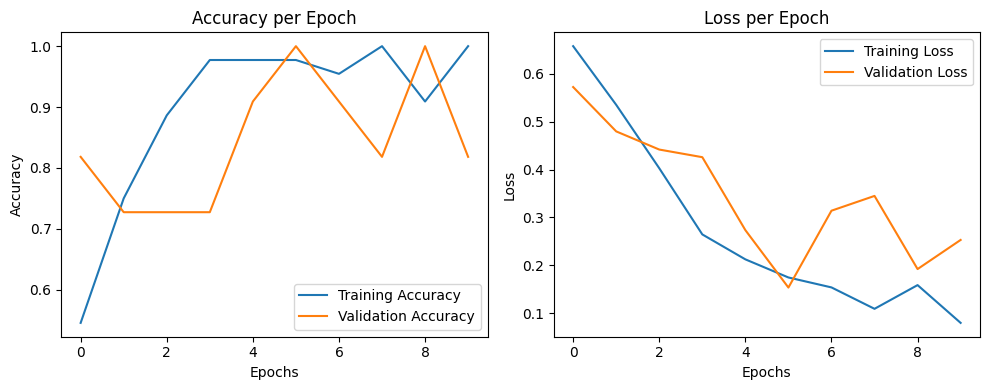

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    # Extract the loss and accuracy values from the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_loss_accuracy(history)

In [ ]:
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model('/content/crime-(a)15.h5')  # Replace with your model path

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# from sklearn.metrics import confusion_matrix

# Assuming binary classification (e.g., 0 or 1)
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Thresholding probabilities to labels
cm = confusion_matrix(y_test, y_pred)

class_names = ['crime', 'non-crime']

print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
[[6 1]
 [0 4]]


In [ ]:
def plot_confusion_matrix(cm, class_names, normalize=False):
  """Plots a normalized or raw confusion matrix with class labels.

  Args:
      cm (numpy.ndarray): The confusion matrix.
      class_names (list, optional): List of class names (default: None).
      normalize (bool, optional): Whether to normalize the confusion matrix values
        (show percentage of misclassified samples with respect to total per class).
  """

  plt.figure(figsize=(6, 4))
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.title('Normalized Confusion Matrix')
  else:
    plt.title('Confusion Matrix')

  sns.heatmap(cm, annot=True, cmap='Blues')

  if class_names is not None:
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

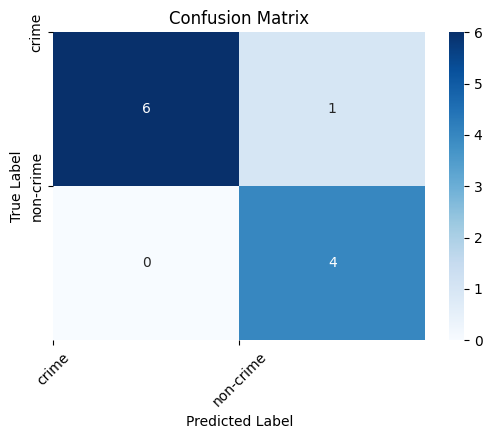

In [ ]:
plot_confusion_matrix(cm, class_names, normalize=False)

In [ ]:
def classify_video(model, video_path):
    video_frames = preprocess_video(video_path)
    video_frames = np.expand_dims(video_frames, axis=0)  # Add batch dimension
    prediction = model.predict(video_frames)
    print(prediction)
    return "Crime" if prediction[0][0] > 0.25 else "Non-Crime"

# Example usage
video_path = "/content/sih/crime/Fighting010_x264.mp4"
result = classify_video(model, video_path)
print(f"The video is classified as: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
[[0.2892978]]
The video is classified as: Crime
